# Solving Gaussian Mixture Model for a distribution, with backprop. 

<a target="_blank" href="https://colab.research.google.com/github/yaoshiang/Gaussian-Mixture-Models-via-Backprop-and-Expectation-Maximization/blob/main/gmm.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This was an attempt to solve for the parameters of a 1D GMM model with backprop. 

Backprop is an optimization technique to solve problems posed as a Maximum Likelihood Estimation (MLE) problem. MLE says that the parameters of a model that are most likely to match the data are the best ones. This is different from Bayesian estimation, which treats a model's parameters as a distribution, not a single point. 

Fitting a GMM model with MLE is not obvious. The insight is that the probablity of a point can be calculcated directly through the Probably Density Function (PDF) of each of the component Gaussians. Any poorly fitting model should show a worse likelihood of fitting the data. 

Next, we attempt to solve the problem with probably the most used technique for MLE problems: backprop. Backprop converges to the optimal result in some cases, but suboptimal in others, which leads me to believe this is a local minima problem. Local minima are statistically impossible in deep learning given the very high dimensionaity, but in this case, we are dealing with very low dimensionality. 

Finally, implement the Expectation Maximization (EM) algorithm, a different algorithm to solve MLE problems. EM resembles k-means clustering in that it alternates between assigning datapoints to a centroid, and then updating the centroids. EM also alternaties between assigning datapoints to a probability distribution of centroids, and then updates those centroids. 

## First, some imports.

In [14]:
from tqdm import tqdm
import torch 
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Setup some basic math functions and utilities. 

In [15]:
def check_numerics(tensor, message='tensor contains NaN or Inf'):
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        raise ValueError(message + str(tensor))
    
def check_zeros(tensor, message='tensor contains zeros'):
    if torch.any((tensor == 0)):
        raise ValueError(message + str(tensor))

def norm_pdf(x, mu, sigma):
  retval = (1. / torch.sqrt(2 * 3.1415927410125732 * sigma**2)) * torch.exp(-((x - mu)**2) / (2 * sigma**2))
  check_numerics(retval)
  return retval

def log_norm_pdf(x, mu, sigma):
  check_zeros(sigma)

  log_pdf = -0.5 * (torch.log(2 * torch.tensor(3.1415927410125732)) + 2 * torch.log(sigma) + ((x - mu) / sigma)**2)

  check_numerics(log_pdf)
  return log_pdf

def log_sum_exp(values, dim=None):
    """Numerically stable implementation of the operation"""
    m = torch.max(values, dim=dim, keepdim=True)[0]
    values0 = values - m
    return m + torch.log(torch.sum(torch.exp(values0), dim=dim, keepdim=True))


## The loss function of a GMM.

The simple understanding of this algorithm is as follows. The actual implementation
  works in log space for numerical stability. 

  We want a GMM that fits the data. 
  MLE says that the model fits best when the likelihood of the params given the data is
  highest. That's equivalent to the probably of the data given the params. L(T | X) = P (X | T). 
  The swapping of the params (theta) and the data (x) when looking at Likelihood (L) and probably (P)
  is the essence of MLE. So we just need to adjust the model params theta (T) to maximize
  the joint probability of the data, P(X)

  For each datapoint, calculcate it's probability. 
  * The prob is the weighted sum of the probs of each component. 
  * The probability of the datapoint given that component is the PDF of the normal distribution. That's not intuitive!  
  * Take the product of each point's prob to get the joint prob, optimize this up. That's MLE! 

  But we never multiply a bunch of small numbers together - that triggers underflow, so we 
  do the math in log space, and we optimize the log of product of the probs. That's
  equivalent to optimizing the sum of the logs of the probs.

  For each datapoint, we calculcate it's log-likelihood, as the log_normal_pdf. 
  Then we add the log of the weight (which is multiplication of the weight). 
  Then we logsumexp the logs. The exp gives us a real prob. We sum them over
  the components. Then we take the log. Formulating it this way allows us to
  do the logsumexp in one numerically stable function. 


In [26]:
def loss(data, weights, means, stds):
  """Compute the loss for a GMM as the negative of the log likelihood.

  Params:
    data: The actual data. Does not need to sum to one.
    component: A three dimensional numpy array, organized as (k, 3). Each row is a component, and each 
      column is a parameter. The first column is the weight, the second is the mean, and the third is the
      standard deviation."""
  
  if isinstance(weights, (int, float, complex)):
    weights = torch.tensor([weights])
  if isinstance(means, (int, float, complex)):
    means = torch.tensor([means])
  if isinstance(stds, (int, float, complex)):
    stds = torch.tensor([stds])
  
  N, K = data.size(0), len(weights)
  log_weighted_pdfs = torch.zeros(N, K)  # Initialize a 2D tensor to store the log-weighted PDF values
  
  for k in range(K):
      log_component_pdf = log_norm_pdf(data, means[k], stds[k])  # Log-probability of data under k-th Gaussian component
      log_weighted_pdfs[:, k] = log_component_pdf + torch.log(weights[k])  # Store log-weighted probability for each data point
  
  log_sum_per_data_point = log_sum_exp(log_weighted_pdfs, dim=1)  # Sum log-probabilities across components for each data point
  neg_log_likelihood = -torch.mean(log_sum_per_data_point)  # mean log-sums across all data points
  
  return neg_log_likelihood

def plot_gmm_histogram(data, weights, means, stds):
    # Create a grid of x values to evaluate the PDF
    x = torch.linspace(min(data), max(data), 1000)

    gmm_pdfs = torch.stack([w * norm_pdf(x, mu=m, sigma=s) for w, m, s in zip(weights, means, stds)], dim=0)

    # Plot histogram
    plt.hist(data, bins=20, density=True, alpha=0.5, color='g', label='Data Histogram')

    # Plot each GMM component
    for i, gmm_pdf in enumerate(gmm_pdfs, 1):
        plt.plot(x, gmm_pdf.detach().numpy(), label=f'GMM Component {i}')

    # Plot the sum of the GMM components
    plt.plot(x, gmm_pdfs.sum(0).detach().numpy(), label='GMM Sum', linestyle='dashed')

    # Print data histogram values
    counts, bins, _ = plt.hist(data, bins=20, density=True, alpha=0)
    # print(f'Histogram Counts: {counts}')
    # print(f'Bin Edges: {bins}')

    # Add legend and labels
    plt.legend(loc='upper right')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title('Histogram and GMM Components')

    # Show the plot
    plt.show()

Let's empirically prove that a GMM model with a zero mean and unit variance fits our data, and that any deviation of the GMM model results in a worse loss value. 

In [17]:
data = torch.randn(100000)

perfect = loss(data, 1, 0, 1)
print(f'The loss at the perfect GMM model is: {perfect}.')

imperfect = loss(data, 1, 0.1, 1)
print(f'The loss with a slightly offset mean is: {imperfect}, worse by {imperfect - perfect}.')

imperfect = loss(data, 1, -.1, 1)
print(f'The loss with a slightly offset std is: {imperfect}, worse by {imperfect - perfect}.')

imperfect = loss(data, 1, 0, 0.9)
print(f'The loss with a slightly offset mean is: {imperfect}, worse by {imperfect - perfect}.')

imperfect = loss(data, 1, 0, 1.1)
print(f'The loss with a slightly offset std is: {imperfect}, worse by {imperfect - perfect}.')

imperfect = loss(data, 1, 0.5, 1)
print(f'The loss with a very offset mean is: {imperfect}, worse by {imperfect - perfect}.')

imperfect = loss(data, 1, 1, 0.5)
print(f'The loss with a very offset std is: {imperfect}, worse by {imperfect - perfect}.')

imperfect = loss(data, 1, 1, 1.5)
print(f'The loss with a very offset std is: {imperfect}, worse by {imperfect - perfect}.')


The loss at the perfect GMM model is: 1.4158622026443481.
The loss with a slightly offset mean is: 1.420275330543518, worse by 0.004413127899169922.
The loss with a slightly offset std is: 1.421449065208435, worse by 0.005586862564086914.
The loss with a slightly offset mean is: 1.427064061164856, worse by 0.011201858520507812.
The loss with a slightly offset std is: 1.4249293804168701, worse by 0.009067177772521973.
The loss with a very offset mean is: 1.5379279851913452, worse by 0.12206578254699707.
The loss with a very offset std is: 4.190011978149414, worse by 2.7741498947143555.
The loss with a very offset std is: 1.7648727893829346, worse by 0.3490105867385864.


## Great. Let's formalize the GMM model in code and setup two approaches to solve for the parameters of the GMM (weights, means, and variances for each component gaussian).

In [18]:
class GMM(torch.nn.Module):
  def __init__(self, n_components):
    super(GMM, self).__init__()
    self.n_components=n_components
    self.weights_logit=torch.nn.Parameter(torch.zeros(n_components), requires_grad=True)
    self.means=torch.nn.Parameter(torch.zeros(n_components), requires_grad=True)
    self.stds_logit=torch.nn.Parameter(torch.zeros(n_components), requires_grad=True)

  def initialize(self, data):
    def linspace_median(start, stop, num, requires_grad=True):
      if num == 1:
          return torch.tensor([(start + stop) / 2], requires_grad=requires_grad)
      else:
          return torch.linspace(start, stop, num, requires_grad=requires_grad)
    
    assert data.dim() == 1, data.dim()
    mean = torch.mean(data)
    std = torch.std(data)

    weights_logit = torch.tensor([0.0] * self.n_components, requires_grad=True)
    centroids = linspace_median(mean -  std, mean + std, self.n_components, requires_grad=True)
    stds_logit = torch.tensor([torch.log(std / self.n_components)] * self.n_components, requires_grad=True)

    with torch.no_grad():  # Disable gradient tracking while updating the parameter
        self.weights_logit.data.copy_(weights_logit)
        self.means.data.copy_(centroids)
        self.stds_logit.data.copy_(stds_logit)

  def forward(self):
    weights = torch.nn.functional.softmax(self.weights_logit)
    means = self.means
    stds = torch.exp(self.stds_logit)

    return weights, means, stds


def fit_backprop(model, data, epochs=1000):
  optimizer = torch.optim.AdamW([model.weights_logit, model.means, model.stds_logit], lr=.1)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=False)

  print('data mean/std', torch.mean(data), torch.std(data))
  print('loss on uninitialized model', loss(data, *model()))

  with tqdm(range(epochs), 'fitting gmm') as pbar:
    previous_loss_val = torch.tensor(float('inf'))
    for epoch in pbar:
      optimizer.zero_grad()
      weights, means, stds = model()
      loss_val = loss(data, weights, means, stds)
      loss_val.backward()
      torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0) 
      optimizer.step()
      scheduler.step(loss_val)     

      pbar.set_postfix({'Epoch': epoch, 'loss': loss_val})

      if previous_loss_val <= loss_val:
        print('loss not decreasing, stopping')
        break
      else:
        previous_loss_val = loss_val


def fit_em(model, data, epochs=1000):
  with tqdm(range(epochs), 'fitting gmm') as pbar:
    previous_loss_val = torch.tensor(float('inf'))
    for epoch in range(epochs):
      # E-step: expectation.
      log_gamma = torch.zeros((data.size(0), model.n_components))  
      new_weights_log = torch.zeros_like(model.weights_logit)
      new_means = torch.zeros_like(model.means)
      new_stds_log = torch.zeros_like(model.stds_logit)

      for i, (w, m, s) in enumerate(zip(*model())):
          log_gamma[:, i] = torch.log(w) + log_norm_pdf(data, mu=m, sigma=s)  

      # Normalize to add up to one: e.g. 0.2 and 0.8.
      log_gamma -= log_sum_exp(log_gamma, dim=1)

      # M-step: Maximization. update the estimates for mean, stds, and weights based on the new gammas
      for i in range(model.n_components):
          component_effective_points = log_gamma[:, i].exp().sum()  # Effective number of points assigned to this component.

          new_weights_log[i] = torch.log(component_effective_points) - torch.log(torch.tensor(data.size(0)))  # update weight. 
          new_means[i] = (log_gamma[:, i].exp() @ data) / component_effective_points  # new mean = weighted average of points.
          var = (log_gamma[:, i].exp() @ (data - new_means[i])**2) / component_effective_points  # update variance
          new_stds_log[i] = torch.log(torch.sqrt(var))  # update std in log space

      # Update the model parameters
      model.weights_logit.data.copy_(new_weights_log)
      model.means.data.copy_(new_means)
      model.stds_logit.data.copy_(new_stds_log)
      
      # Compute log-likelihood to check for convergence (optional)
      loss_val = loss(data, *model())

      pbar.set_postfix({'Epoch': epoch, 'loss': loss_val})

      if previous_loss_val <= loss_val:
        print('loss increased, stopping')
        break
      else:
        previous_loss_val = loss_val


def test_backprop(n_components, data):
  gmm = GMM(n_components)
  gmm.initialize(data)

  weights, means, stds = gmm()
  print('components after init, before fitting', weights.detach().numpy(), means.detach().numpy(), stds.detach().numpy())

  fit_backprop(gmm, torch.tensor(data))

  weights, means, stds = gmm()
  print('components after fitting', weights.detach().numpy(), means.detach().numpy(), stds.detach().numpy())

  plot_gmm_histogram(data, weights, means, stds)

def test_em(n_components, data):
  gmm = GMM(n_components)
  gmm.initialize(data)

  weights, means, stds = gmm()
  print('components after init, before fitting', weights.detach().numpy(), means.detach().numpy(), stds.detach().numpy())

  fit_em(gmm, torch.tensor(data))

  weights, means, stds = gmm()
  print('components after fitting', weights.detach().numpy(), means.detach().numpy(), stds.detach().numpy())

  plot_gmm_histogram(data, weights, means, stds)

## Fitting a unimodal gaussian works just fine. 

/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(self.weights_logit)
/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fit_backprop(gmm, torch.tensor(data))


components after init, before fitting [1.] [-0.00096357] [1.002759]
data mean/std tensor(-0.0010) tensor(1.0028)
loss on uninitialized model tensor(1.4217, grad_fn=<NegBackward0>)


fitting gmm:   0%|          | 1/1000 [00:00<00:21, 47.11it/s, Epoch=1, loss=tensor(1.4367, grad_fn=<NegBackward0>)]

loss not decreasing, stopping
components after fitting [1.] [0.00862301] [0.97761416]


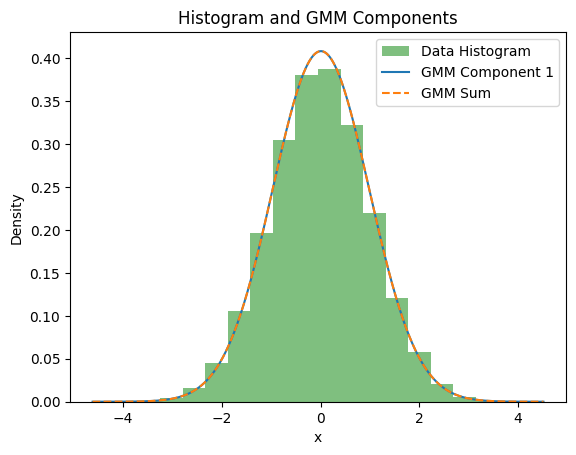

In [19]:
data = torch.randn(100000)
test_backprop(1, data)

## Fitting a one component GMM to a bi-model works fine too. 

/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(self.weights_logit)
/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fit_backprop(gmm, torch.tensor(data))


components after init, before fitting [1.] [0.9062388] [3.0958157]
data mean/std tensor(0.9062) tensor(3.0958)
loss on uninitialized model tensor(2.5490, grad_fn=<NegBackward0>)


fitting gmm:   0%|          | 1/1000 [00:00<00:15, 63.14it/s, Epoch=1, loss=tensor(2.5600, grad_fn=<NegBackward0>)]


loss not decreasing, stopping
components after fitting [1.] [0.8726665] [3.0114229]


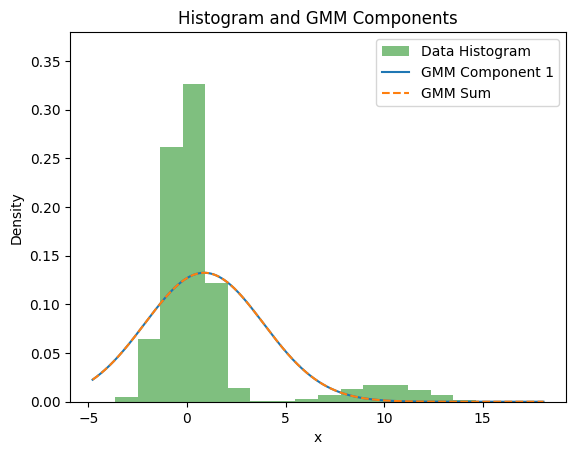

In [20]:
data = torch.cat([torch.randn(100000), torch.randn(10000) * 2 + 10])
test_backprop(1, data)

## But a bimodal distribution creates problems. The second hump cannot simulatenously increase weight while shifting the mean. 

/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(self.weights_logit)
/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fit_backprop(gmm, torch.tensor(data))


components after init, before fitting [0.5 0.5] [-2.1770358  3.9923897] [1.5423564 1.5423564]
data mean/std tensor(0.9077) tensor(3.0847)
loss on uninitialized model tensor(3.5240, grad_fn=<NegBackward0>)


fitting gmm:   2%|▏         | 23/1000 [00:00<00:07, 134.94it/s, Epoch=23, loss=tensor(1.8641, grad_fn=<NegBackward0>)]


loss not decreasing, stopping
components after fitting [0.88784236 0.11215764] [0.07102534 5.05015   ] [0.8399747 6.850086 ]


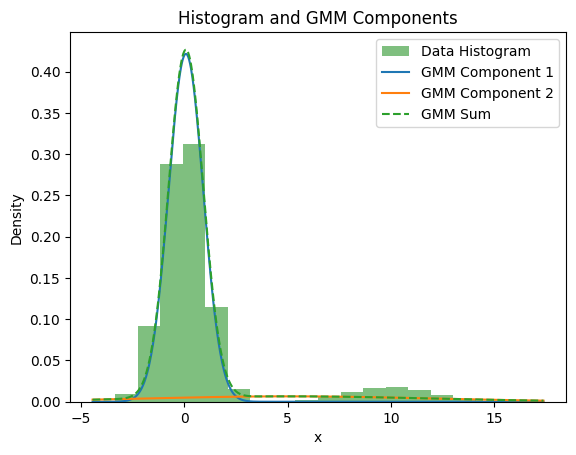

In [21]:
data = torch.cat([torch.randn(100000), torch.randn(10000) * 2 + 10])
test_backprop(2, data)


## Running Expectation Maximization (EM) instead of a backprop solves the problem perfectly. 

/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(self.weights_logit)
/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fit_em(gmm, torch.tensor(data))


components after init, before fitting [0.5 0.5] [-2.1850185  4.0023904] [1.5468522 1.5468522]


fitting gmm:   0%|          | 0/1000 [00:00<?, ?it/s, Epoch=12, loss=tensor(1.7875, grad_fn=<NegBackward0>)]


loss increased, stopping
components after fitting [0.9090863  0.09091379] [-1.9726600e-03  1.0014759e+01] [1.0010927 2.0100636]


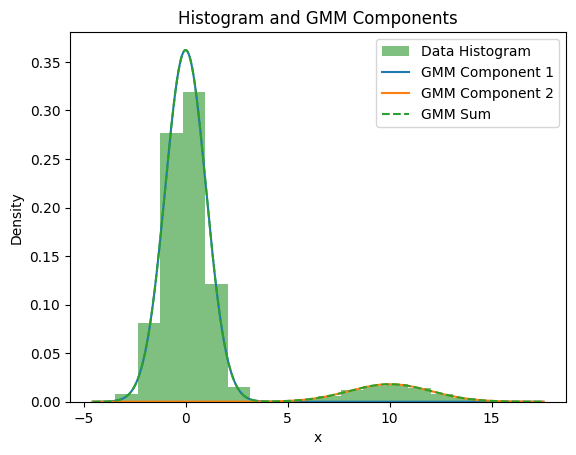

In [22]:
data = torch.cat([torch.randn(100000), torch.randn(10000) * 2 + 10])
test_em(2, data)

## So let's try it with some crazy distributions. 

Once again, a small second bump will give the backprop algo a problem, while the EM algorithm handles it no problem. 

/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(self.weights_logit)
/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fit_backprop(gmm, torch.tensor(data))


components after init, before fitting [0.5 0.5] [0.23122364 1.372633  ] [0.2853523 0.2853523]
data mean/std tensor(0.8019) tensor(0.5707)
loss on uninitialized model tensor(1.7942, grad_fn=<NegBackward0>)


fitting gmm:   0%|          | 0/1000 [00:00<?, ?it/s, Epoch=4, loss=tensor(0.6171, grad_fn=<NegBackward0>)]

fitting gmm:   1%|          | 12/1000 [00:00<00:22, 44.75it/s, Epoch=12, loss=tensor(0.1499, grad_fn=<NegBackward0>)]


loss not decreasing, stopping
components after fitting [0.91019636 0.0898036 ] [0.55957836 2.1131198 ] [0.16833372 0.8376026 ]


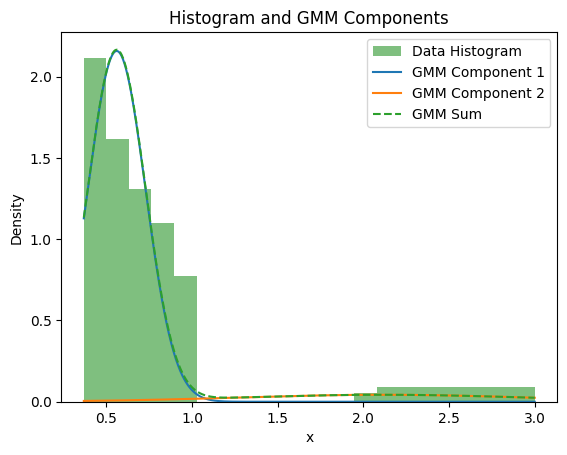

In [45]:
# Generate exponential bumps
x1 = torch.exp(-torch.linspace(0, 1, 100000))
x2 = torch.linspace(2, 3, 10000)
# Combine the distributions
data = torch.cat((x1, x2))

test_backprop(2, data)

As before, a second small bump gives 

/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(self.weights_logit)
/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fit_em(gmm, torch.tensor(data))


components after init, before fitting [0.5 0.5] [0.23122364 1.372633  ] [0.2853523 0.2853523]


fitting gmm:   0%|          | 0/1000 [00:00<?, ?it/s, Epoch=8, loss=tensor(0.0567, grad_fn=<NegBackward0>)]


loss increased, stopping
components after fitting [0.9090909  0.09090913] [0.6321211 2.4999995] [0.18098798 0.28870496]


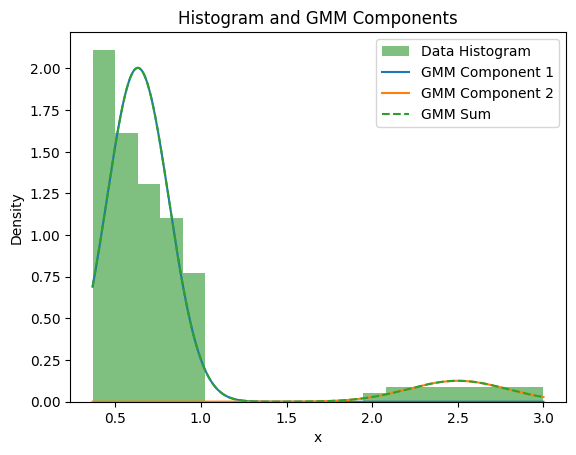

In [46]:
test_em(2, data)

## Just for fun, let's see how the algos handle a 10 component GMM. 

/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(self.weights_logit)
/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fit_backprop(gmm, torch.tensor(data))


components after init, before fitting [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] [0.23122364 0.3580469  0.48487017 0.61169344 0.7385167  0.86533993
 0.9921632  1.1189865  1.2458097  1.372633  ] [0.05707046 0.05707046 0.05707046 0.05707046 0.05707046 0.05707046
 0.05707046 0.05707046 0.05707046 0.05707046]
data mean/std tensor(0.8019) tensor(0.5707)
loss on uninitialized model tensor(19.1498, grad_fn=<NegBackward0>)


fitting gmm:   1%|▏         | 13/1000 [00:00<01:07, 14.68it/s, Epoch=13, loss=tensor(-0.0306, grad_fn=<NegBackward0>)]


loss not decreasing, stopping
components after fitting [0.05176318 0.11419168 0.15359516 0.14941554 0.15935355 0.09422483
 0.07637949 0.06242394 0.05185808 0.08679462] [0.7743258  0.7117014  0.40539622 0.55630624 0.59713477 0.8524149
 0.4671296  0.8564941  0.85238385 2.675797  ] [0.06394208 0.07138502 0.02671668 0.07284937 0.09070177 0.09371183
 0.08719383 0.08253581 0.07848648 0.22038776]


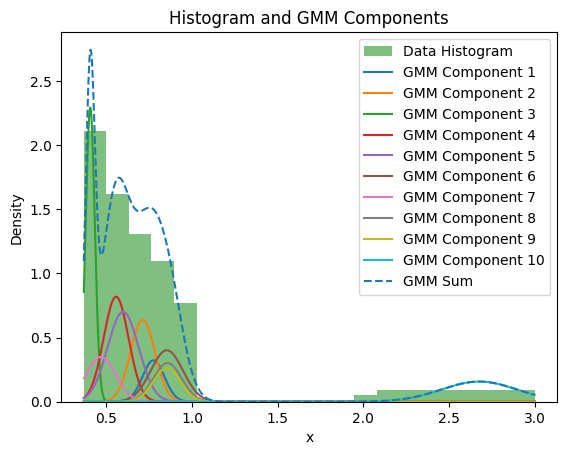

In [43]:
test_backprop(10, data)

/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = torch.nn.functional.softmax(self.weights_logit)
/var/folders/sp/xq8y9z3j22g_rw699h_9d3080000gp/T/ipykernel_75422/4066277924.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fit_em(gmm, torch.tensor(data))


components after init, before fitting [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] [0.23122364 0.3580469  0.48487017 0.61169344 0.7385167  0.86533993
 0.9921632  1.1189865  1.2458097  1.372633  ] [0.05707046 0.05707046 0.05707046 0.05707046 0.05707046 0.05707046
 0.05707046 0.05707046 0.05707046 0.05707046]


fitting gmm:   0%|          | 0/1000 [01:04<?, ?it/s, Epoch=999, loss=tensor(-0.1256, grad_fn=<NegBackward0>)]


components after fitting [0.02504812 0.05948095 0.11092599 0.18288621 0.3143408  0.12625751
 0.05488706 0.02531367 0.00995055 0.09090909] [0.37467352 0.39444733 0.43576148 0.5133403  0.66392595 0.83661693
 0.92551947 0.97116035 0.9926628  2.5       ] [0.00427635 0.01178137 0.02558028 0.04936922 0.08791173 0.05429005
 0.02783146 0.01270051 0.00458325 0.28870445]


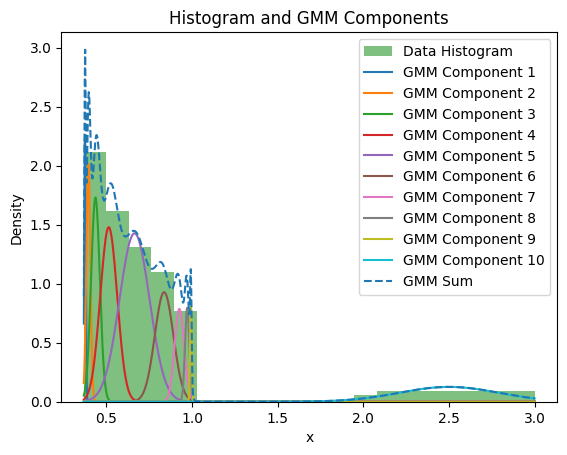

In [44]:
test_em(10, data)